In [1]:
# load our dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import lognorm
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline
plt.style.use("ggplot")

## Optimizing Hyper-parameters for Machine Learning

**Objective:** Compare hyper-parameter results found through grid search and random search in predicting tweet sentiment.

Notebook adapted from https://github.com/justmarkham/scikit-learn-videos/blob/master/08_grid_search.ipynb

In [2]:
# read in our labeled twitter data
df = pd.read_csv("data/sts_gold_tweet.csv",  sep=";")

print "Total rows:", df.shape[0]
df.iloc[213:217]

Total rows: 2034


,id,polarity,tweet
213,1559513777,0,I can't find my Ipod Just tore the living ro...
214,1995955627,1,Going to Brians graduation. Wearing Taylor Swi...
215,1833721929,0,@KidFco0L LMAO my throat hurts... Man I told m...
216,2177370539,1,@taylorswift13 you're soooo talented and I wis...


In [3]:
# convert tweets into bag-of-words to use as model features
vectorizer = CountVectorizer()
bag_of_words = vectorizer.fit_transform(df["tweet"])

# create X (features) and y (response)
X = bag_of_words
y = df.polarity

### Manual parameter search using `cross_val_score`

In [4]:
# initialize a logistic regression classifier with the regularization constant C=1 (the default)
logreg = LogisticRegression(C=1)

# run a 10-fold cross-validation with our classifier
scores = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')

print scores

[ 0.83902439  0.85853659  0.82758621  0.86699507  0.8817734   0.87684729
  0.87192118  0.83251232  0.80788177  0.85221675]


In [5]:
# use average accuracy as an estimate of out-of-sample accuracy
print scores.mean()

0.851529496576


In [6]:
# search for an optimal value of C for logistic regression
c_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
c_scores = []

# for each C value, run a 10-fold cross validation and return the average accuracy score
for c in c_range:
    clf = LogisticRegression(C=c)
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    c_scores.append(scores.mean())

# print out the average accuracy scores for each C value
for s in c_scores:
    print s

0.689285113541
0.718793704193
0.820031238736
0.851529496576
0.851515078698
0.851539108495
0.850061275982


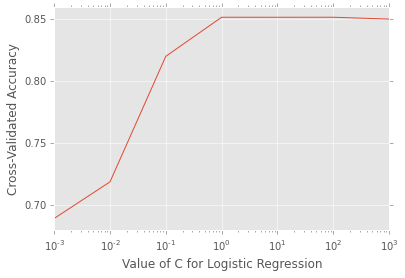

In [7]:
# plot the value of C (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(c_range, c_scores)
plt.xlabel("Value of C for Logistic Regression")
plt.ylabel("Cross-Validated Accuracy")
plt.xscale("log")

### Automating our parameter search using `GridSearchCV`

In [8]:
# define the parameter values that should be searched
c_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(C=c_range)
print param_grid

{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}


In [9]:
# instantiate the grid
grid = GridSearchCV(clf, param_grid, cv=10, scoring="accuracy")

# fit the grid with data
grid.fit(X, y)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='accuracy', verbose=0)

In [10]:
# view the complete results (list of named tuples)
grid.grid_scores_

[mean: 0.68928, std: 0.00074, params: {'C': 0.001},
 mean: 0.71878, std: 0.01100, params: {'C': 0.01},
 mean: 0.82006, std: 0.02383, params: {'C': 0.1},
 mean: 0.85152, std: 0.02293, params: {'C': 1},
 mean: 0.85152, std: 0.02930, params: {'C': 10},
 mean: 0.85152, std: 0.02869, params: {'C': 100},
 mean: 0.85005, std: 0.03140, params: {'C': 1000}]

In [11]:
# examine the first tuple
print grid.grid_scores_[0].parameters
print grid.grid_scores_[0].cv_validation_scores
print grid.grid_scores_[0].mean_validation_score

{'C': 0.001}
[ 0.68780488  0.68780488  0.68965517  0.68965517  0.68965517  0.68965517
  0.68965517  0.68965517  0.68965517  0.68965517]
0.689282202557


In [13]:
# create a list of the mean scores for plotting the results
grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
print grid_mean_scores

[0.68928220255653883, 0.71878072763028511, 0.82005899705014751, 0.85152409046214361, 0.85152409046214361, 0.85152409046214361, 0.85004916420845622]


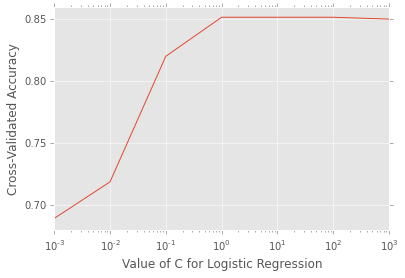

In [14]:
# plot the results
plt.plot(c_range, grid_mean_scores)
plt.xlabel("Value of C for Logistic Regression")
plt.ylabel("Cross-Validated Accuracy")
plt.xscale("log")

In [15]:
# examine the best model
print grid.best_score_
print grid.best_params_
print grid.best_estimator_

0.851524090462
{'C': 1}
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)


### Searching multiple parameters simultaneously
- Example: tuning the regularization `penalty` and `C` for logistic regression
- Could tune parameters independently: change `penalty` while leaving `C` at its default value, and vice versa
- But, best performance might be achieved when neither parameter is at its default value

In [16]:
# define the parameter values that should be searched
c_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
penalties = ["l1", "l2"]

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(C=c_range, penalty=penalties)
print param_grid

{'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}


In [17]:
# instantiate and fit the grid
grid = GridSearchCV(clf, param_grid, cv=10, scoring="accuracy")
grid.fit(X, y)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='accuracy', verbose=0)

In [18]:
# view the complete results
grid.grid_scores_

[mean: 0.68928, std: 0.00074, params: {'penalty': 'l1', 'C': 0.001},
 mean: 0.68928, std: 0.00074, params: {'penalty': 'l2', 'C': 0.001},
 mean: 0.68928, std: 0.00074, params: {'penalty': 'l1', 'C': 0.01},
 mean: 0.71878, std: 0.01100, params: {'penalty': 'l2', 'C': 0.01},
 mean: 0.74533, std: 0.01496, params: {'penalty': 'l1', 'C': 0.1},
 mean: 0.82006, std: 0.02383, params: {'penalty': 'l2', 'C': 0.1},
 mean: 0.83382, std: 0.01955, params: {'penalty': 'l1', 'C': 1},
 mean: 0.85152, std: 0.02293, params: {'penalty': 'l2', 'C': 1},
 mean: 0.84710, std: 0.02362, params: {'penalty': 'l1', 'C': 10},
 mean: 0.85152, std: 0.02930, params: {'penalty': 'l2', 'C': 10},
 mean: 0.84366, std: 0.02112, params: {'penalty': 'l1', 'C': 100},
 mean: 0.85152, std: 0.02869, params: {'penalty': 'l2', 'C': 100},
 mean: 0.84366, std: 0.02732, params: {'penalty': 'l1', 'C': 1000},
 mean: 0.85005, std: 0.03140, params: {'penalty': 'l2', 'C': 1000}]

In [19]:
# examine the best model
print grid.best_score_
print grid.best_params_

0.851524090462
{'penalty': 'l2', 'C': 1}


### Reducing computational expense using `RandomizedSearchCV`
- Searching many different parameters at once may be computationally expensive
- RandomizedSearchCV searches a subset of the parameters, and you control the computational "budget"

In [20]:
# define the parameter values that should be searched
stddev = 5
mean = 0
c_range = lognorm(s = stddev, loc = mean)
penalties = ["l1", "l2"]

- **Important**: Specify a continuous distribution (rather than a list of values) for any continous parameters
- Here is a comprehensive list of statistical distribution functions from Scipy. http://docs.scipy.org/doc/scipy/reference/stats.html

In [21]:
# create a parameter grid: map the parameter names to the values that should be searched
param_dist = dict(C=c_range, penalty=penalties)
print param_dist

{'penalty': ['l1', 'l2'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x108c48090>}


In [22]:
# n_iter controls the number of searches
rand = RandomizedSearchCV(clf, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=5)
rand.fit(X, y)
rand.grid_scores_

[mean: 0.83579, std: 0.02584, params: {'penalty': 'l2', 'C': 0.26205863797699064},
 mean: 0.84857, std: 0.02378, params: {'penalty': 'l1', 'C': 5.9000102543523205},
 mean: 0.76401, std: 0.01361, params: {'penalty': 'l2', 'C': 0.030183410954111325},
 mean: 0.85251, std: 0.02914, params: {'penalty': 'l2', 'C': 10.851457935577598},
 mean: 0.84464, std: 0.02369, params: {'penalty': 'l1', 'C': 22.611705337921464},
 mean: 0.84464, std: 0.02450, params: {'penalty': 'l1', 'C': 9.6860133576251037},
 mean: 0.84366, std: 0.01751, params: {'penalty': 'l1', 'C': 1.2162118876369601},
 mean: 0.83776, std: 0.02339, params: {'penalty': 'l2', 'C': 0.33323312700779611},
 mean: 0.68928, std: 0.00074, params: {'penalty': 'l1', 'C': 0.0066556639378277964},
 mean: 0.84317, std: 0.02029, params: {'penalty': 'l1', 'C': 136.0172863463157}]

In [23]:
# examine the best model
print rand.best_score_
print rand.best_params_

0.852507374631
{'penalty': 'l2', 'C': 10.851457935577598}


In [24]:
best_scores = []

# run RandomizedSearchCV 20 times (with n_iter=10) and record the best score
for _ in range(20):
    rand = RandomizedSearchCV(clf, param_dist, cv=10, scoring='accuracy', n_iter=10)
    rand.fit(X, y)
    best_scores.append(round(rand.best_score_, 3))

# each time random search can achieve comparable accuracy scores as the best grid search result using fewer tries
print sorted(best_scores)

[0.847, 0.851, 0.851, 0.852, 0.852, 0.852, 0.852, 0.852, 0.852, 0.852, 0.852, 0.853, 0.853, 0.853, 0.853, 0.853, 0.853, 0.854, 0.854, 0.855]


### Using the best parameters to make predictions

In [25]:
# make a prediction on out-of-sample data
new_tweet = "It's too hot today. I'm melting."
new_tweet_bow = vectorizer.transform([new_tweet])

In [26]:
print "best random search parameters", rand.best_params_
print "best grid search parameters", grid.best_params_

best random search parameters {'penalty': 'l2', 'C': 4.8173143722824454}
best grid search parameters {'penalty': 'l2', 'C': 1}


In [27]:
# GridSearchCV and RandomizedSearchCV automatically refits the best model using all of the data
print "random search predicts", rand.predict(new_tweet_bow)
print "grid search predicts", grid.predict(new_tweet_bow)

random search predicts [0]
grid search predicts [0]
